# Basic regression: Predict fuel efficiency

회귀문제의 목적은 가격 또는 확률과 같은 연속적인 값의 출력을 예측하는 것이다. 이것을 클래스 목록에서 클래스를 선택하는 것이 목저인 **분류** 문제와 대조해보기

이번 노트북은 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터 세트를 사용하고 1970년대 후반과 1980년대 초반 자동차의 연비를 예측하는 모델을 구축합니다.

## Auto MPG Data Set

### 1.Abstract
1. Data Set Characteristics: Multivariate
2. Attribute Caaracteristics: Categorical, Real
3. Associated Task: Regression
4. Number of Instances: 398
5. Number of Attributes: 8
6. Missing Value: Yes
7. Area: N/A
8. Date Donated: 1993-07-07
9. Number of Web Hits: 672678

### 2. Attribute Information

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [58]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


# 1. The Auto MPG dataset

## Get the data

First download and import the dataset using pandas

In [59]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [60]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

The dataset contains a few unknown values.

In [61]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [62]:
dataset = dataset.dropna()

In [63]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 'Horsepower'의 결측치가 사라짐

The "Origin" column is really categorical, not numeric. So convert that to a one-hot with pd.get_dummies:

In [64]:
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})

In [65]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix=' ', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [66]:
# DataFrame으로 부터 특정 비율의 표본을 무작위로 추출하기 (fraction)

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other.

[데이터 시각화](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=youji4ever&logNo=221995887346)

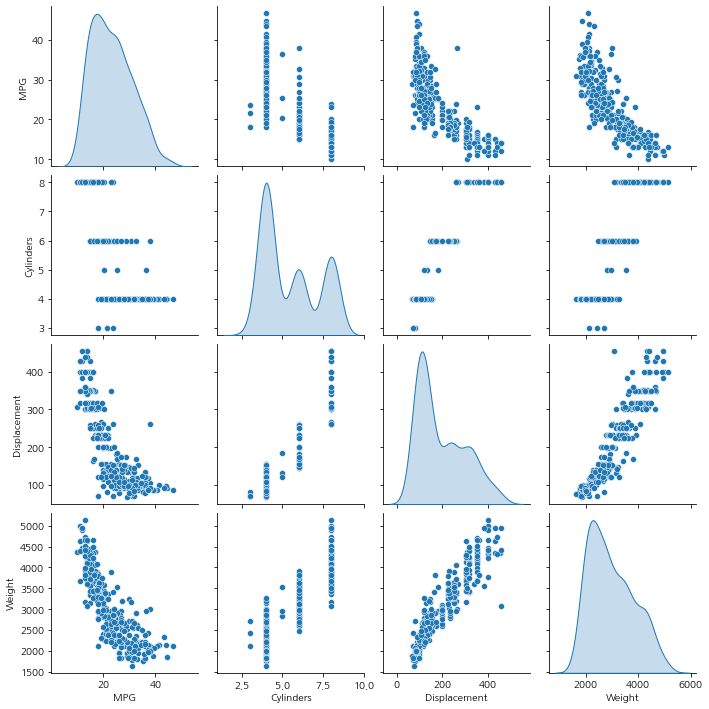

In [23]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']],
            diag_kind='kde')

# diag_kind = 'kde' : 밀도 플롯 출력

Also look at the overall statistics, note how each feature covers a very different range:

In [24]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [67]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [68]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

## The Normalization layer

The **preprocsessing.Normalization** layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [69]:
normalizer = preprocessing.Normalization(axis=-1)

Then **.adapt()** it to the data:

In [70]:
normalizer.adapt(np.array(train_features))

This calculates the mean and varivance, and stores them in the layer.

In [71]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


When the layer is called it returns the input data, with each feature independently normalized:

In [73]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict MPG from Horsepower.
Training a model with **tf.keras** typically starts by defining the model architecture.
In this case use a **keras.Sequential** model. This model represents a sequence of steps.
In this case there are two steps:

   - Normalize the input **horsepower**
   - Apply a linear transformation (y=mx+b) to produce 1 output using **layers.Dense**
    
The number of inputs can either be set by the **input_shape** argument, or automatically when the model is rum for the first time.

First create the horsepower **Normalization** layer:

In [74]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1, ], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the sqeuential model:

In [75]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict MPG from Horsepower.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, (10,1):

In [76]:
horsepower_model.predict(horsepower[:10])

array([[-0.769],
       [-0.434],
       [ 1.419],
       [-1.078],
       [-0.975],
       [-0.383],
       [-1.155],
       [-0.975],
       [-0.254],
       [-0.434]], dtype=float32)

Once the model is built, configure the training procedure using the **Model.compile()** method. The most important arguments to compile are the loss and the **optimizer** since these define what will be optimized (**mean_absolute_error**) and how (using the **optimizers.Adam**).

In [77]:
horsepower_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                        loss='mean_absolute_error')

Once the training is configured, use Model.fit() to execute the training:

In [78]:
%%time
history = horsepower_model.fit(train_features['Horsepower'], train_labels,
                              epochs=100,
                              # suppress logging
                              verbose=0,
                              # Calculate validation results on 20% of the training data
                              validation_split = 0.2)

Wall time: 1.82 s


Visualize the model's training progress using the stats stored in the **history** object.

In [79]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804930,4.175877,95
96,3.804757,4.185900,96
97,3.805651,4.203593,97
98,3.802702,4.194727,98
99,3.803309,4.186593,99


In [80]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

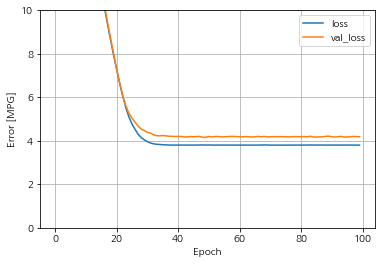

In [81]:
plot_loss(history)

Collect the results on the test set, for later:

In [82]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
test_features['Horsepower'],
test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [83]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [84]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

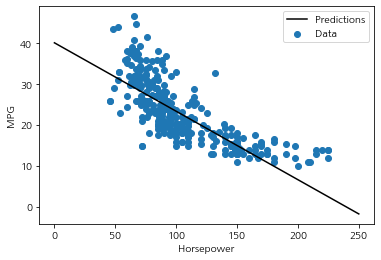

In [85]:
plot_horsepower(x,y)

## Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same y= mx+b except that m is a matrix and b is a vector.

This time use the **Normalization** layer that was adapted to the whole dataset.

In [86]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces units=1 outputs for each example.

In [87]:
linear_model.predict(train_features[:10])

array([[-0.045],
       [-0.284],
       [-1.784],
       [ 0.223],
       [ 1.036],
       [-0.064],
       [ 1.361],
       [ 2.222],
       [-0.162],
       [ 0.774]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the kernel (the m in y = mx+b) has a shape of (9,1).

In [88]:
linear_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.545],
       [-0.138],
       [-0.301],
       [-0.656],
       [ 0.421],
       [ 0.075],
       [ 0.353],
       [-0.244],
       [-0.487]], dtype=float32)>

Use the same compile and fit calls as for the single input horsepower model:

In [89]:
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                    loss='mean_absolute_error')

In [90]:
%%time
history = linear_model.fit(train_features, train_labels,
                          epochs=100,
                          # suppress logging
                          verbose=0,
                          # calculate validation on 20% of the training ddata
                          validation_split=0.2)

Wall time: 1.83 s


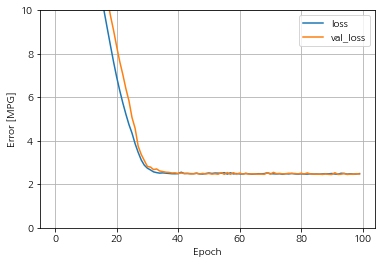

In [91]:
plot_loss(history)

collect the results on the test set, for later:

In [95]:
test_results['linear_model'] = linear_model.evaluate(test_features,
                                                     test_labels,
                                                     verbose=0)

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

   - The normalization layer.
   - Two hidden, nonlinear, Dense layers using the relu nonlinearity.
   - A linear single-output layer.
   
Both will use the same training procedure so the **compile** method is included in the **build_and_compile_model** function below.

In [96]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                 optimizer=tf.keras.optimizers.Adam(0.001)) 
    
    return model

## One variable

Start with a DNN model for a single input: "Horsepower"

In [98]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [99]:
dnn_horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [101]:
%%time
history = dnn_horsepower_model.fit(train_features['Horsepower'],
                                  train_labels,
                                  validation_split=0.2,
                                  verbose=0,
                                  epochs=100)

Wall time: 2 s


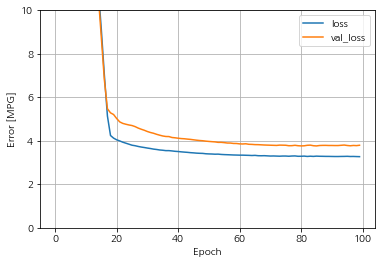

In [102]:
plot_loss(history)

If you plot the predictions as a function of Horsepower, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [105]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

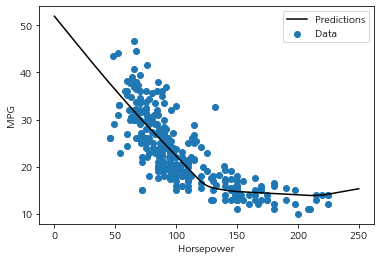

In [106]:
plot_horsepower(x, y)

Collect the results on the test set, for later:

In [109]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
                                       test_features['Horsepower'],
                                       test_labels, verbose=0)

## Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [110]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [111]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 2 s


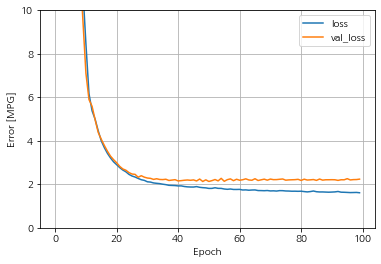

In [112]:
plot_loss(history)

Collect the results on the test set:

In [113]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels,
                                              verbose=0)

## Performance

Now that all the models are trained check the test-set performance and see how they did:

In [114]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.647892
linear_model,2.494358
dnn_horsepower_model,2.931417
dnn_model,1.747847


These results match the validation error seen during training.

## Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

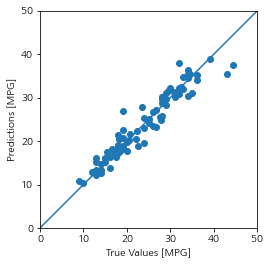

In [115]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It looks like the model predicts reasonably well.

Now take a look at the error distribution:

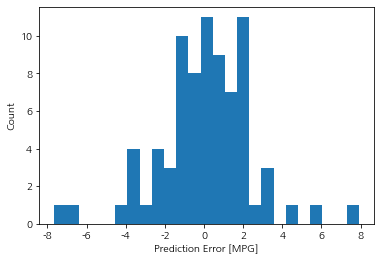

In [116]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model save it for later use:

In [117]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [118]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [119]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.647892
linear_model,2.494358
dnn_horsepower_model,2.931417
dnn_model,1.747847
reloaded,1.747847


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

   - Mean Squared Error (MSE) and Mean Absolute Error (MAE) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
   - Similarly, evaluation metrics used for regression differ from classification.
   - When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
   - Overfitting is a common problem for DNN models, it wasn't a problem for this tutorial. See the overfit and underfit tutorial for more help with this.